In [21]:
from map_dm_nav.visualisation_tools import plot_likelihood, pickle_load_model, plot_state_in_map
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors

In [22]:
from map_dm_nav.obs_transf.observation_match import ViewMemory
from map_dm_nav.model.V5 import Ours_V5_RW
from map_dm_nav.model.odometry import PoseOdometry

In [23]:
import matplotlib
# matplotlib.use('TkAgg')
%matplotlib inline

## plot visualisation

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_transitions(B: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action."""
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig


In [25]:
def compare_B1_B2_plots(B1: np.ndarray, B2: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action.
       Common values in B1 and B2 (within a margin of 0.1) are set to 0 in the resulting B.
    """
    
    # Create B by zeroing out common values within margin 0.1
    margin = 0.1
    B = np.where(np.abs(B1 - B2) <= margin,0, B2)
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig, B

# Model

In [26]:
model_dir = '/home/idlab332/workspace/ros_ws/tests/small_ware/1/step_26'

In [27]:
ob_id = -1
pose_id = -1

In [28]:
Views = ViewMemory(matching_threshold=0.7)

#load model
model = pickle_load_model(model_dir)
Views.set_memory_views(model.get_memory_views())
#self.model.policy_len = 5

#Didn't exist during exploration runs (they were fixed parameters, not self)
model.num_simulations = 30  # Number of MCTS simulations per planning step
model.max_rollout_depth = 10 # Maximum depth for the simulation (rollout) phase
model.c_param = 5

#We changed some methods so, we need to consider them
pose_memory = PoseOdometry(model.possible_actions, model.influence_radius, model.robot_dim)
pose_memory.odometry = model.PoseMemory.odometry
pose_memory.poses = model.PoseMemory.poses 


### PLot Model before change

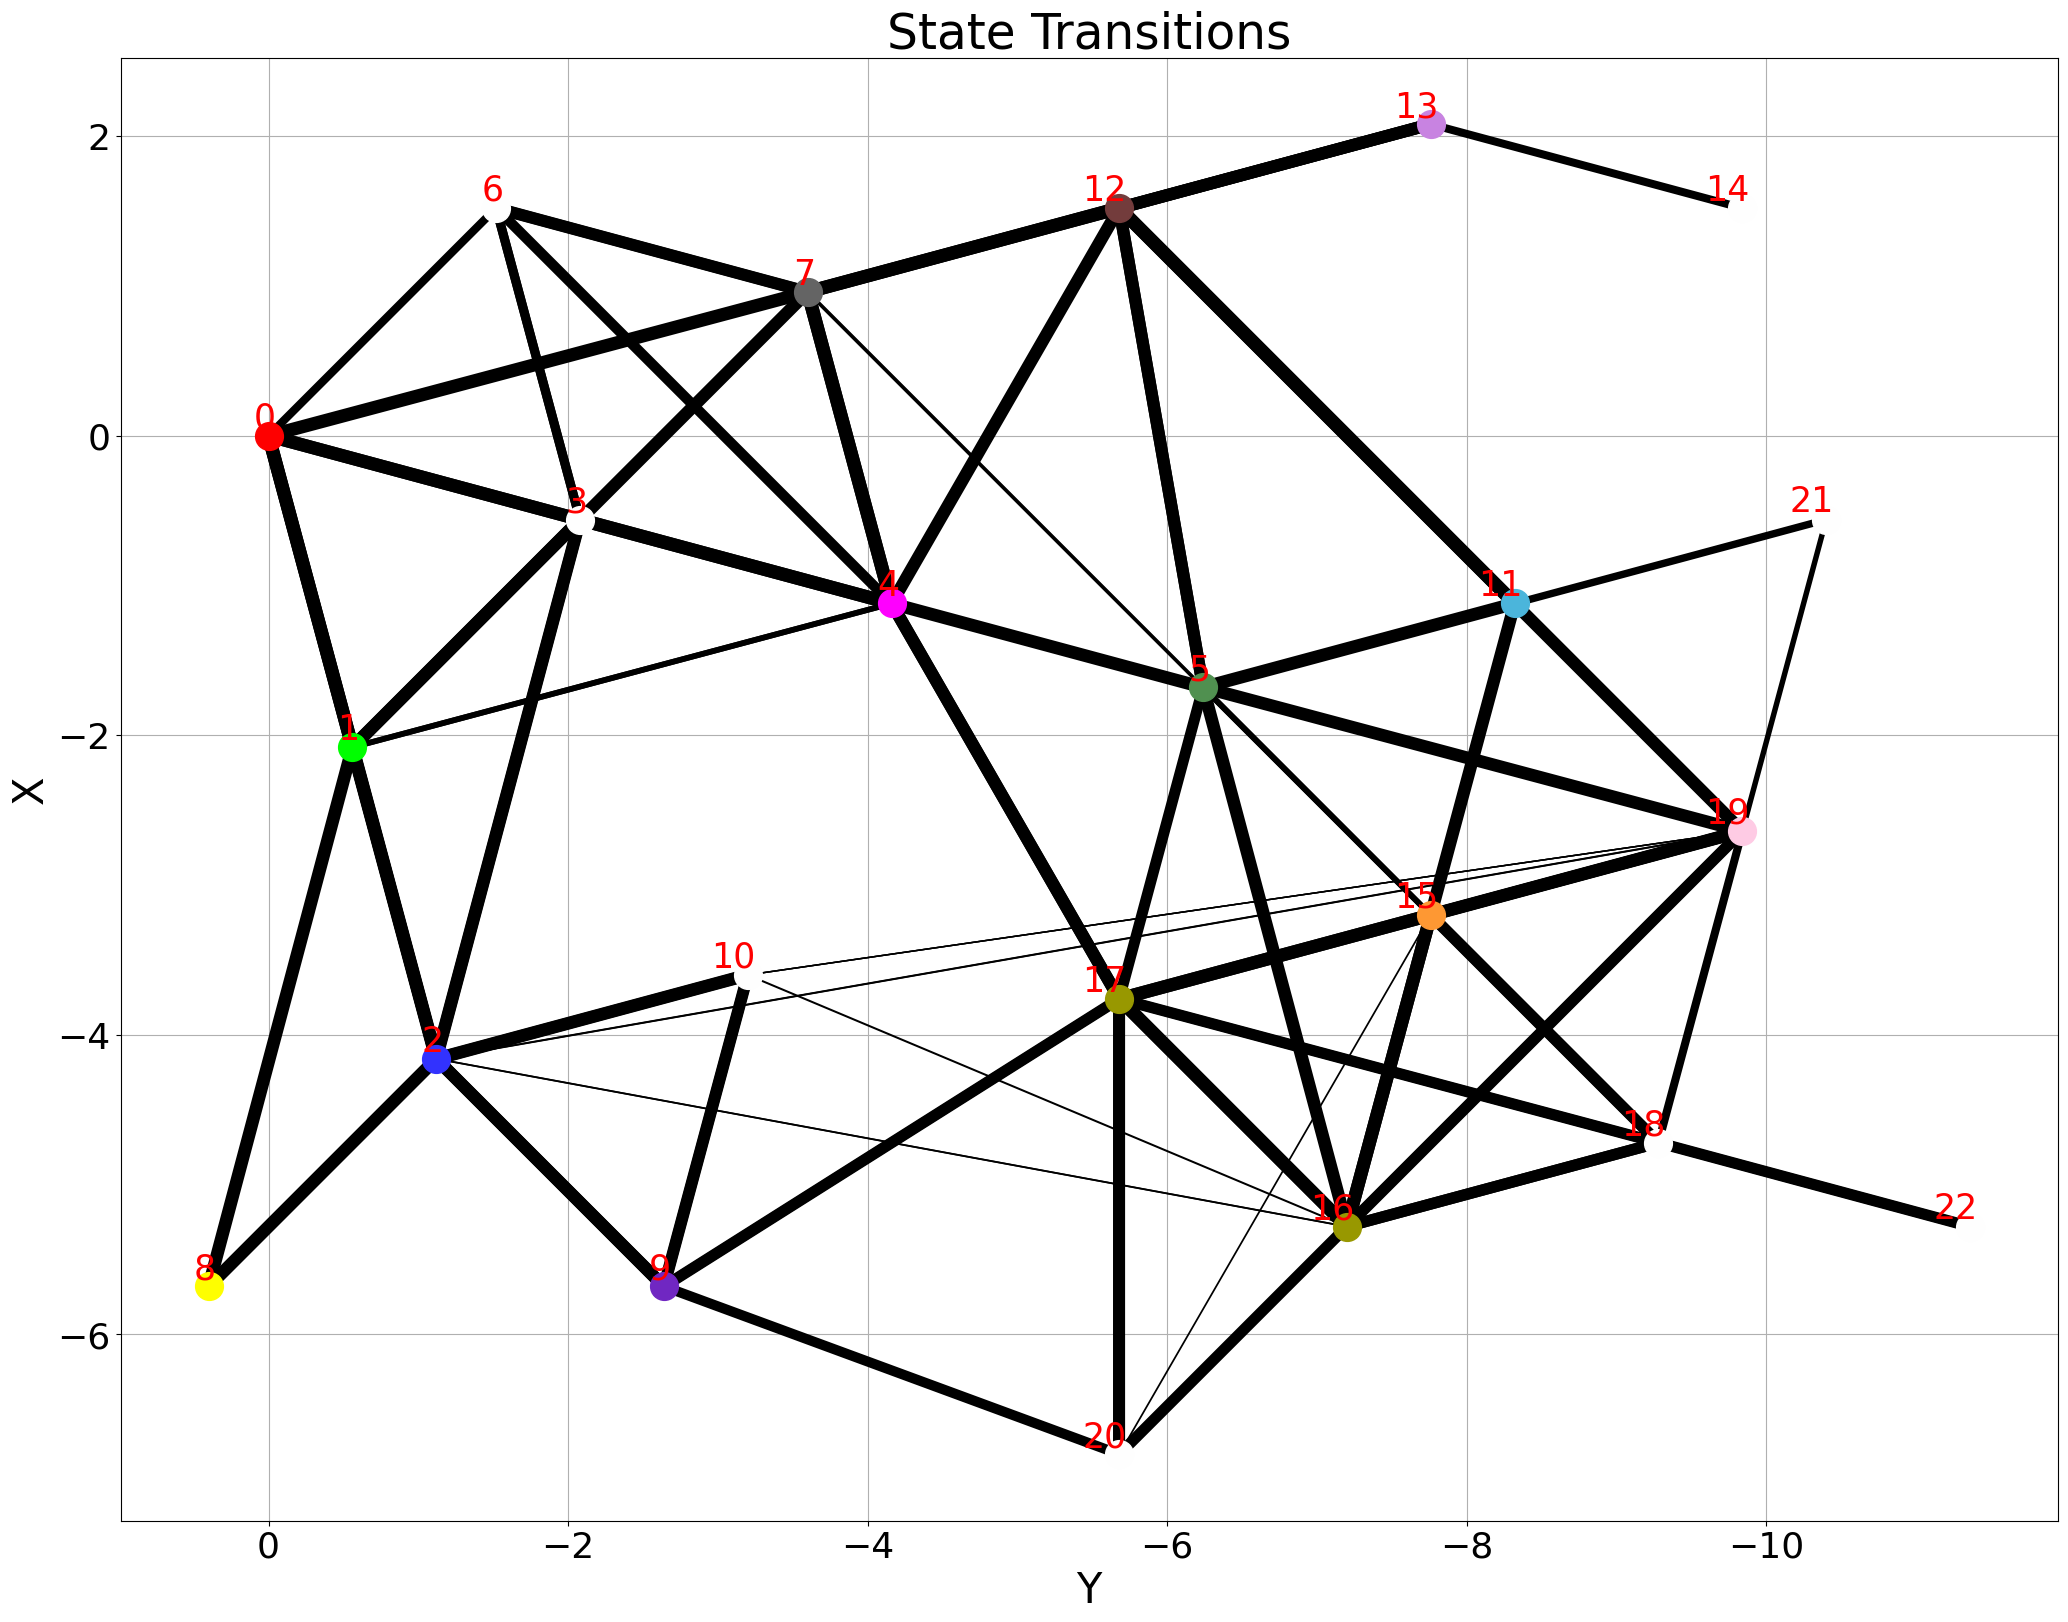

In [29]:
fig = plot_state_in_map(model.get_B(), model.get_agent_state_mapping())
plt.grid('True')
fig.canvas.draw()


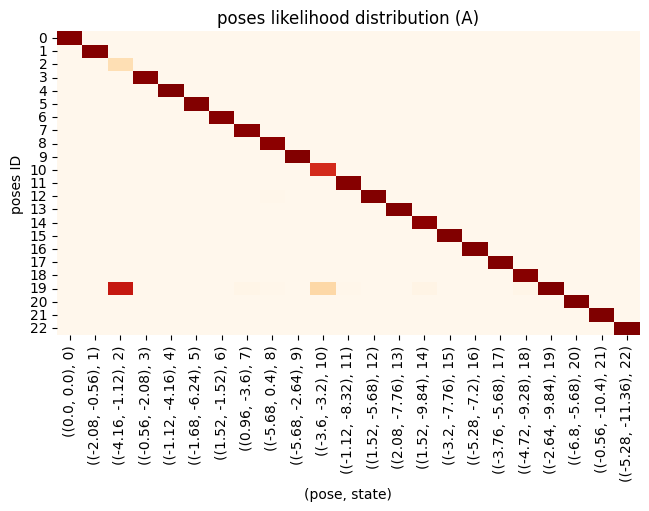

In [30]:
A = plot_likelihood(model.get_A()[1], model.get_agent_state_mapping(), \
                        'poses')

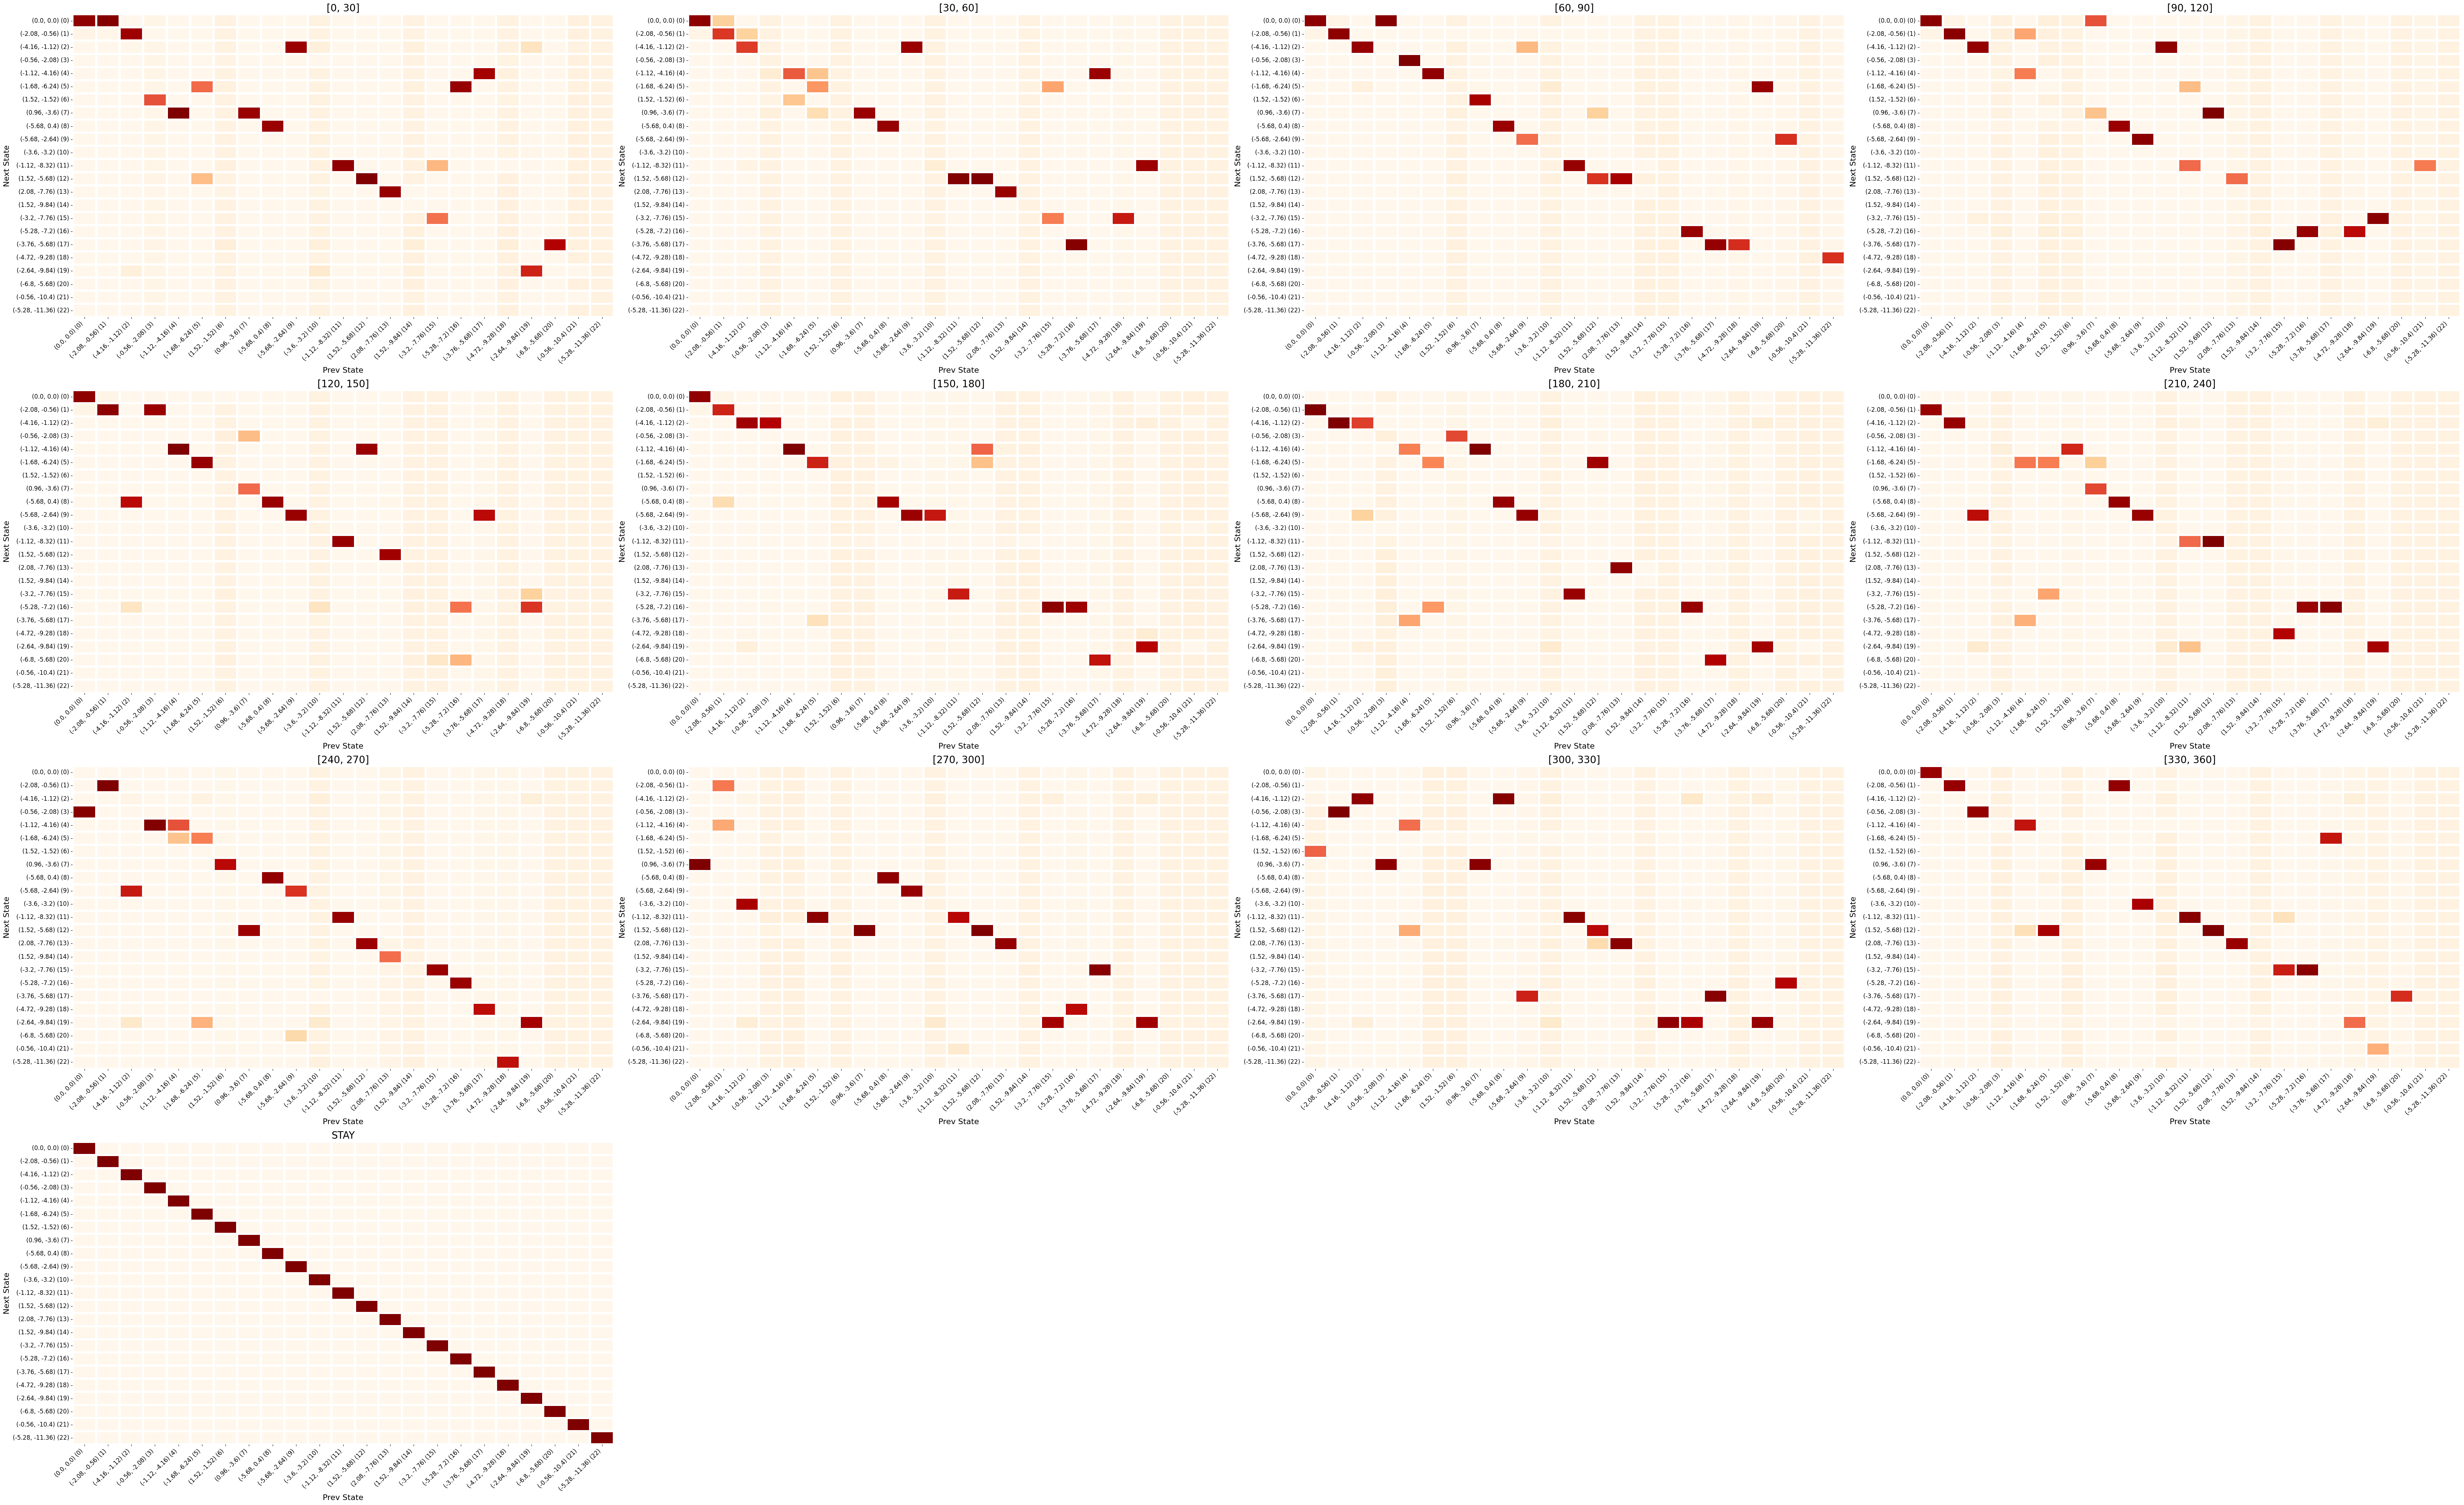

In [31]:
B = plot_transitions(model.get_B(), model.get_agent_state_mapping(), model.possible_actions)

## add a new node at position X

In [ ]:
def inject_new_node_given_pose(self,pose_memory,pose):
    #We want this new pose to be added, even if there are other poses in the model influence_radius. Basically if there are no poses at 10cm distance, we will create a new one.
    pose_id = self.PoseMemory.pose_to_id(pose, odom = pose, save_in_memory=True, influence_radius=0.1)

    #Make sure the model can accept new state
    self.update_A_dim_given_pose(pose_id)
    self.update_B_dim_given_A()
    self.update_C_dim()
    self.update_qs_dim()

    


    return self



In [33]:
model = inject_new_node_given_pose(model,pose_memory, pose= (-2, -4))

In [34]:
pose_id

-1

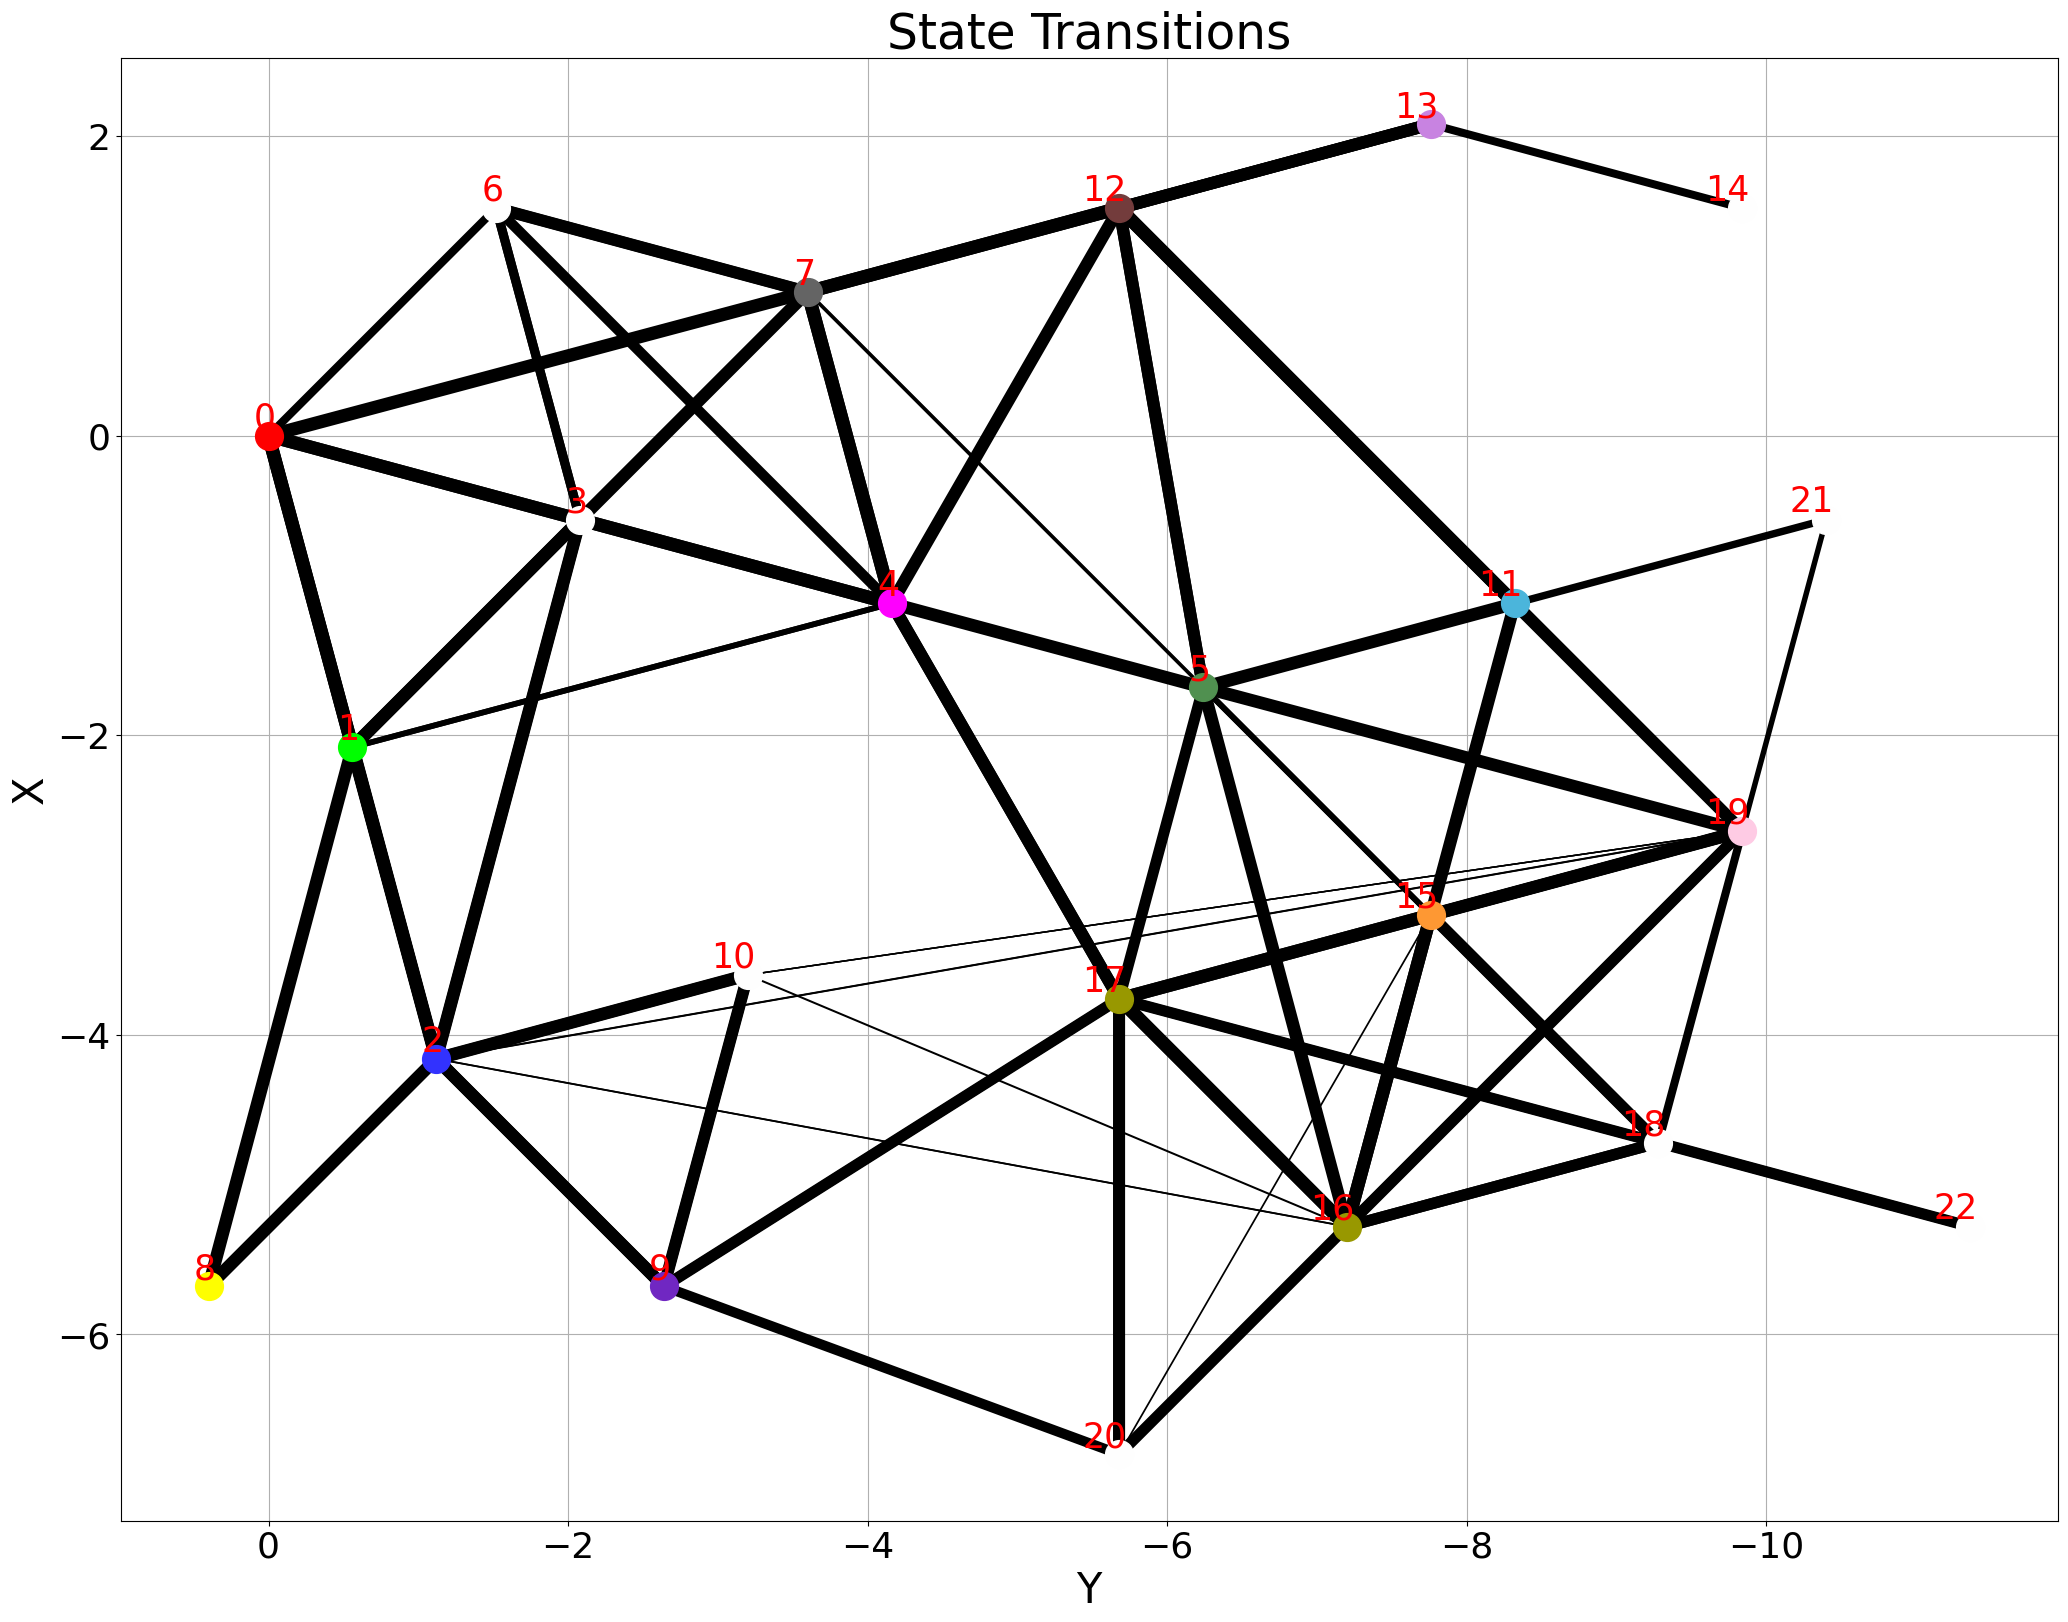

In [35]:
fig = plot_state_in_map(model.get_B(), model.get_agent_state_mapping())
plt.grid('True')
fig.canvas.draw()

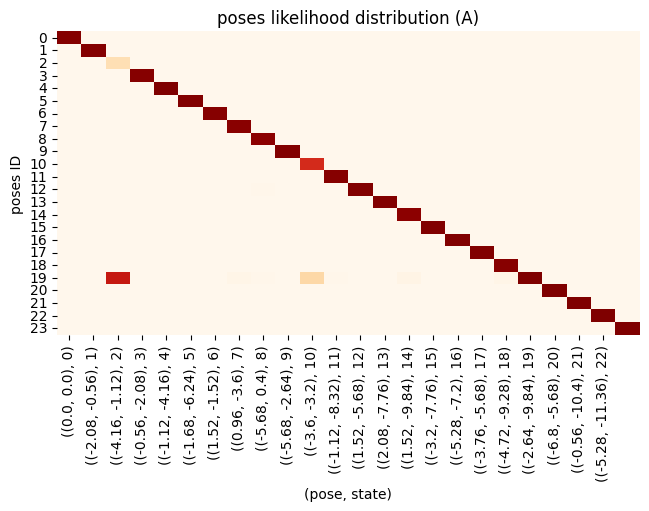

In [36]:
A = plot_likelihood(model.get_A()[1], model.get_agent_state_mapping(), \
                        'poses')